# Predicting Cognitive Ability From Demographic Data

Authors: Anmin Yang & Shan Gao

Cognitive training is a non-pharmacological approach that helps maintain or even increase people's cognitive ability.<br>
Numerious applications have been developed as gyms of brain.<br>
These applications will face a common problem: to taylor training program specific to customers' ability.<br>
For example, a person with high cognitive ability should participate in challenging brain exercise,<br> 
instead of fundamental recovery program designed for cognitive impaired people. 

In this project, we frame this demand into a classification problem. <br>
We intend to classify people into two classes (high VS low cognitive ability) based on their demographic data.

In [1]:
import numpy as np
import pandas as pd 
import os 

import matplotlib.pyplot as plt 
import seaborn as sns 

## Part 1: Data Overview and Preprocessing (Shan Gao & Anmin Yang)

### 1.1 Data Overview

We choose Battery 50 as our target battery.<br>
This battery covers a wide range of tests from arithmetic ability to memory.

In [2]:
# load data 
df = pd.read_csv('data/battery50_df.csv')

# get shape
print(df.shape)

# get feature names 
print(df.columns)

(2302948, 11)
Index(['user_id', 'age', 'gender', 'education_level', 'country', 'test_run_id',
       'battery_id', 'specific_subtest_id', 'raw_score', 'time_of_day',
       'grand_index'],
      dtype='object')


In this dataset, both demograhic data and scores of web-based cognitive tests are available.</br>
Each battery consists of several subtests.<br>
The measurement of a participant's cognitive alility is based on the aggregated score of all the subtests within a battery.<br>

- **Features Used for Prediction**
    - **Deomographics**
        - Numerical Feature
            - age
        - Categorical Features 
            - education level
            - gender
            - country 
    - **Test Session Information**
        - Numerical Feature
            - time of day: The time (rounded to hours) a battery is completed
                - For instance: 22 means that this battery is completed at 10 p.m.
- **Outcome Measures**
    - raw score: the score for each subtest
    - grand index : the aggregated cognitive performance score for a battery
- **Identifiers**
    - user id: unique identifier for each participant 
    - test run id: identifier for the entire test session of a participant
        - each participant has only one id 
    - battery id: the identifier of the battery
        - in our case, the value is set to 50
    - specific subset id: the identifiers of the sutests within the current battery
    

Let's see an example of how our data looks

In [3]:
df.head(20)

,user_id,age,gender,education_level,country,test_run_id,battery_id,specific_subtest_id,raw_score,time_of_day,grand_index
0,29,69.0,m,4.0,US,100605,50,29,14.0,22,87.413696
1,29,69.0,m,4.0,US,100605,50,45,28.0,22,87.413696
2,29,69.0,m,4.0,US,100605,50,43,6.0,22,87.413696
3,29,69.0,m,4.0,US,100605,50,44,9.0,22,87.413696
4,29,69.0,m,4.0,US,100605,50,39,53.0,22,87.413696
5,29,69.0,m,4.0,US,100605,50,40,53.0,22,87.413696
6,29,69.0,m,4.0,US,100605,50,30,5.0,22,87.413696
7,29,69.0,m,4.0,US,100605,50,31,10.0,22,87.413696
8,186,30.0,f,6.0,US,324592,50,29,14.0,12,117.608789
9,186,30.0,f,6.0,US,324592,50,45,61.0,12,117.608789


### 1.2 Data Cleaning I

Note there are some redundent columns in our data:<br>

As we have user_id as the unique indentifier of individual, we can drop out: 
- test_run_id

As we have already selected Battery 50 as the battery of interest, we should also drop out: 
- battery_id

In this study, our interst is the overall measurement of participants' cognitive ability (grand_idedx),<br>
not the specific score of an subtest. Therefore, we will drop out:
- specific_subtest_id
- raw_score

In [4]:
# drop rudundent columns 
drop_columns = ['test_run_id', 'battery_id',
                'specific_subtest_id', 'raw_score']
df.drop(drop_columns, axis=1, inplace=True)
print(f'data shape after dropping redundent columns: {df.shape}')

data shape after dropping redundent columns: (2302948, 7)


Next, let's check whether there are observations with incomplete data

In [5]:
# check whether are observations with incomplete data
df.isnull().sum()

user_id                 0
age                     0
gender             126961
education_level    148796
country                 0
time_of_day             0
grand_index        131980
dtype: int64

In [6]:
# drop rows from users with incomplete data
df.dropna(inplace=True)
print(f'data shape after dropping rows with NaN: {df.shape}')

data shape after dropping rows with NaN: (2005720, 7)


The DataFrame now looks like:

In [7]:
df.head(20)

,user_id,age,gender,education_level,country,time_of_day,grand_index
0,29,69.0,m,4.0,US,22,87.413696
1,29,69.0,m,4.0,US,22,87.413696
2,29,69.0,m,4.0,US,22,87.413696
3,29,69.0,m,4.0,US,22,87.413696
4,29,69.0,m,4.0,US,22,87.413696
5,29,69.0,m,4.0,US,22,87.413696
6,29,69.0,m,4.0,US,22,87.413696
7,29,69.0,m,4.0,US,22,87.413696
8,186,30.0,f,6.0,US,12,117.608789
9,186,30.0,f,6.0,US,12,117.608789


Note that the first 8 rows are all for user *29*.<br> 
This is because we ignored indiviual subtests and treat the whole battery as one observation (measured by grand_index),<br> 
we have duplicated rows to eliminate.  

In [8]:
# eliminate duplicated rows 
print(f'Before dropping duplicated rows, data shape is {df.shape}')

df = df.drop_duplicates()

print(f'After dropping, data shape is {df.shape}')

Before dropping duplicated rows, data shape is (2005720, 7)
After dropping, data shape is (250715, 7)


We have 250715 valid observations in total. 

### 1.3 Data Transformation

In our study, we treated the prediciton problem as a **classification problem**.<br>
Specifically, we considered subjects with high GI score as class of **high** cognitive ability,<br>
and subjects with low GI score as class of **low** cognitive ability. 

Let's first look at the distribution of the GI score. 

count    250715.000000
mean        103.902534
std          14.370122
min          34.552308
25%          94.380208
50%         103.867340
75%         113.448786
max         167.512534
Name: grand_index, dtype: float64


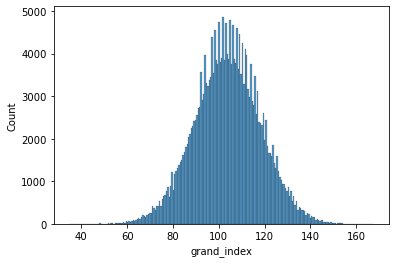

In [9]:
sns.histplot(data=df, x='grand_index')
print(df['grand_index'].describe())
plt.savefig('figs/gi_distribution.png', dpi=200)

We observed a normally distributed GI score with mean at around 100 and std at 14.<br>
To explore the possibility of differentiating the cognitive ability from demographic data,<br>
(reducing difficulty)<br>
we converted this natually prediction problem into a classification problem. <br>

Specifically, we treat subjects with top 25% GI score as high cognitive ability subjects,<br>
and subjects with with the bottom 25% GI score as low cognitive ability subjects.<br>
This procedure results in using half of the observants as training and testing dataset. 

In [10]:
# determining the number of observations in each class
num_of_class = round(df.shape[0] * 0.25) # 25% of all observants in each class
print(f'For each class, we have {num_of_class} observations.')

# sort dataframe
df.sort_values('grand_index', inplace=True) # in ascending order 

df_low = df.head(num_of_class).copy()
df_high = df.tail(num_of_class).copy()

df_low['cog_ability'] = 'low'  
df_high['cog_ability'] = 'high' 

df_class = pd.concat([df_low, df_high],
                    axis=0,
                    ignore_index=True)

df_class.drop(['grand_index'], axis=1, inplace=True)
print(f'The dataframe for ML is in shape {df_class.shape}')

For each class, we have 62679 observations.
The dataframe for ML is in shape (125358, 7)


As the ML models we apply will operate on the preprocessed data, <br>
we save this dataframe for easy access. 

In [11]:
# save subsetted df for easier future access
df_class.to_csv('data/proj1_df.csv')

### 1.4 Data Cleaning II

In the previous section, we saved our subset of data as a file 'proj1_df.csv' for convinience of future use (so that users don't have to go through the initialy cleaning and subsetting procedures every time).

So the following procedures will start from the 'proj1_df.csv' file.


In [12]:
# read in subsetted data
df_data = pd.read_csv('data/proj1_df.csv')

# drop indexing column
df_data.drop(['Unnamed: 0'], axis=1, inplace=True)

We save the data type regulation step until now to ensure that data types are correct after reading in subsetted data. 

In [13]:
df_data.dtypes

user_id              int64
age                float64
gender              object
education_level    float64
country             object
time_of_day          int64
cog_ability         object
dtype: object

Note that we have 2 tricky features in the dataset: *education_level* and *time_of_day*.<br>

- *education_level* represents the level of education attainment of each participant; it has 9 different levels (1: 'Some high school', 2: 'High school diploma/GED', 3: 'Some college', 4: 'College degree', 5: 'Professional degree', 6: 'Master's degree', 7: 'Ph.D.', 8: "Associate's degree", 99: 'Other'). Should we treat it as a categorical value or ordinal value? We note that these educational levels do not have a strictly ascending order; for example, 'Professional degree' such as JD and MD is assigned a lower level than 'Master's degree' in the dataset, whereas in reallife it is not always the case. Therefore, we treat it as a **categorical value** here.

- *time_of_day* represents the time (see detailed description above) the battery is completed. It is by nature a numeric value as 23 comes later in a day than 22 of the same day. However, it is also circular, meaning that 0 can also come after 23 (instead of being the earlist time of a day). Therefore, we treat it as a **categorical value** here. 

In [14]:
cat_columns = ['user_id', 'gender',
            'education_level', 'country',
            'time_of_day', 'cog_ability']

df_data[cat_columns] = df_data[cat_columns].astype('category')
df_data.dtypes

user_id            category
age                 float64
gender             category
education_level    category
country            category
time_of_day        category
cog_ability        category
dtype: object

### 1.5 Features Selection and Visualization

The previous steps have clarified the features(X) and target(y).<br>
In this section, we will get a sense of the distribution of features before training models.

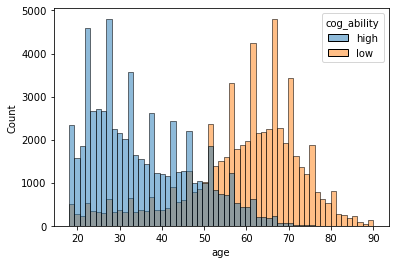

In [15]:
# distribution of age 
sns.histplot(df_data, x='age', hue='cog_ability')
plt.savefig('./figs/age_distribution.png', dpi=200)

We see a clear dissociation of age and cognitive ablity.<br>
This means age would be a good feature to classify cognitive ability.

Male Number : 54424
Female Number : 70934


/Users/anmin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:254: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


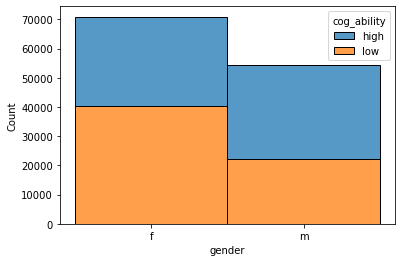

In [16]:
# gender 
sns.histplot(df_data, x='gender', hue='cog_ability', multiple='stack')
print(f"Male Number : {np.sum(df_data['gender']=='m')}")
print(f"Female Number : {np.sum(df_data['gender']=='f')}")
plt.savefig('./figs/gender_distribution.png', dpi=200)

We see a higher propotion of male with high cognitive ability,<br>
which could also be a useful feature in our classification model. 

In [17]:
#df_data['education_level'] = df_data.education_level.replace([99], 9)

education_map = {1: 'Some high school',
                2: 'High school diploma/GED',
                3: 'Some college',
                4: 'College degree',
                5: 'Professional degree',
                6: "Master's degree",
                7: 'Ph.D.',
                8: "Associate's degree",
                99: 'Other'} 
df_data['education_level'] = df_data['education_level'].map(education_map)

/Users/anmin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:254: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

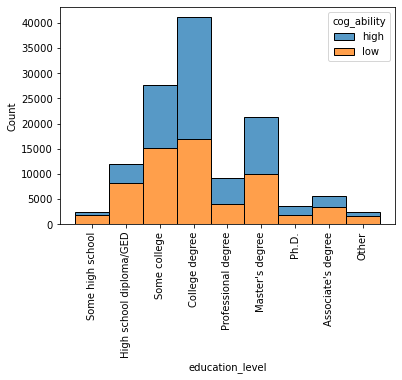

In [18]:
sns.histplot(df_data, x='education_level',hue='cog_ability', multiple='stack')
plt.xticks(rotation=90)

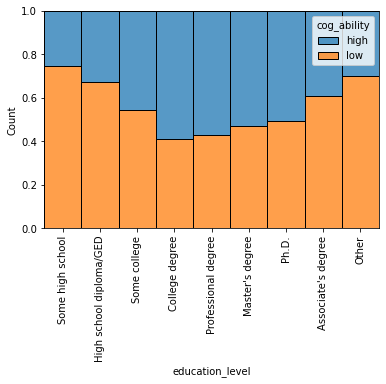

In [19]:
sns.histplot(df_data, x='education_level',hue='cog_ability', multiple='fill')
plt.xticks(rotation=90)
plt.savefig('figs/educational_level_fill.png', dpi=200)

We see different propotion of high VS low cognitive ability in different educational degrees.<br>
Therefore, educational level could be a feature to classify cognitive ability.

/Users/anmin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:249: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  curves.iloc[:, cols] = (curves
/Users/anmin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:254: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


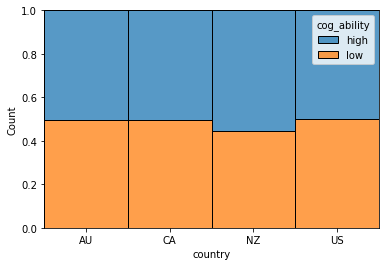

In [19]:
# country
sns.histplot(df_data, x='country',hue='cog_ability', multiple='fill')
plt.savefig('figs/country_fill.png', dpi=200)

Contrary to educational level, there is little variation of cognitive ability class among country.<br>
We would anticipate *country* as a none-predictive featrue for classification. 

/Users/anmin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:249: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  curves.iloc[:, cols] = (curves
/Users/anmin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:254: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


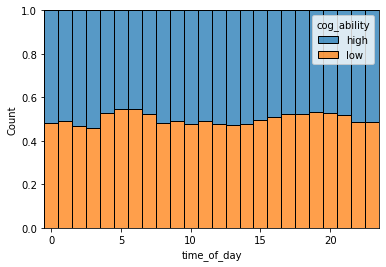

In [20]:
# time_of_day
sns.histplot(df_data, x='time_of_day', hue='cog_ability', multiple='fill')
plt.savefig('./figs/day_time_fill.png', dpi=200)

Similarly, we see little differece in *time_of_day*,<br>
which would be a none-predictive feature in our classification task.<br>
As the purpose of our ML models is to classify participants into distinct cognitive ability groups,<br>
we consider the time one subject complete the whole battery as a **confounding factor**.<br>
Therefore, we will discard this feature in the following model training.

In [21]:
# drop unuseful column
df_data.drop(['time_of_day'], axis=1, inplace=True)

#### Feature Summary

After exploring all the available features, we would anticipate:<br>
- **Predictive Features** 
    - age
    - gender
    - educational level
- **None-predictive Features**
    - country

### 1.6 Check Multicollinearity

We employ **Variance Inflation Factor**(VIF) to detect multicollinearity.<br>
The greater the VIF is, the stronger the collinearity a feature has.<br>

Generally, a VIF above 4 indicates that multicollinearity might exist, and further investigation is required. <br>
When VIF is higher than 10, there is significant multicollinearity that needs to be corrected.

In [22]:
# to calculate VIF, we need to convert strings into categorical representation 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

cat_names = ['gender', 'education_level', 'country']
for col_name in cat_names:
    df_data[col_name] = le.fit_transform(df_data[col_name])
df_data.head(4)

,user_id,age,gender,education_level,country,cog_ability
0,69754110,79.0,0,1,3,low
1,104090018,51.0,1,3,3,low
2,87397599,33.0,0,4,3,low
3,62558139,76.0,1,1,3,low


In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the feature set
variable_df = df_data.iloc[:, 1:-1]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = variable_df.columns
  
# calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(variable_df.values, i)
                          for i in range(len(variable_df.columns))]

vif_data

,feature,VIF
0,age,4.928579
1,gender,1.642837
2,education_level,2.463673
3,country,4.894018


Though we see VIFs of all features except *gender* exceed 4, they are nevertheless not significant.<br>
In our model, we will not drop any feature.

### 1.7 Feature Engineering

For the categorical features, we covert them into one-hot encoded fashion.

Note that according to sklearn documentation [https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html], and since we have already checked for multicollinearity between features before one-hot encoding, we will not be dropping one of the categories per feature as this "breaks the symmetry of the original representation and can therefore induce a bias in downstream models, for instance for penalized linear classification or regression models."

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# create X and y
df_ml = pd.read_csv('data/proj1_df.csv')
df_ml.drop(['Unnamed: 0', 'user_id', 'time_of_day'],
            axis=1, inplace=True)
            
df_ml['education_level'] = df_ml['education_level'].map(education_map)

X = df_ml.drop(['cog_ability'], axis=1)
y = df_ml['cog_ability']

# OHE
transformer = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(),
                                [1, 2, 3])], remainder="passthrough")
X = transformer.fit_transform(X)    

In [28]:
# the three categorical features are coded in the One Hot fashion 
cat_names = transformer.named_transformers_['OneHot'].get_feature_names_out()
print(cat_names)
X = np.asarray(X.todense()) # for the convenience of operating
print(X[0,:]) # with age passed to the end of the matrix 

['gender_f' 'gender_m' "education_level_Associate's degree"
 'education_level_College degree'
 'education_level_High school diploma/GED'
 "education_level_Master's degree" 'education_level_Other'
 'education_level_Ph.D.' 'education_level_Professional degree'
 'education_level_Some college' 'education_level_Some high school'
 'country_AU' 'country_CA' 'country_NZ' 'country_US']
[ 1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 79.]


label categories in y with numerical values

In [29]:
# convert y into category denoted by number 
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['high', 'low'], dtype=object)

check the shape of X and y

In [30]:
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (125358, 16)
y shape is (125358,)


## Part 2: Modeling

### 2.1 Standardization of Numeric Data; Get Training and Test Sets

We perform standardization on numerical data (age) for logistic regression

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[:,-1] = scaler.fit_transform(X[:,-1].reshape(-1,1)).flatten() 

Note that since random forest model is not sensitive to the variance of the dada, we will later transform age back to its original values (use scaler.inverse_transform()) for ease of interpretation.

We then split training and testing data

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

Verify whether classes are splitted equally

In [33]:
from collections import Counter

print(f'Class distribution in test set: {Counter(y_test)}')

Class distribution in test set: Counter({1: 12570, 0: 12502})


As we have equal number of observants in both classes, and the class size is fairly close in test set,<br>
we can conclude that classes are equally splitted. 

### 2.2 Logistic Regression (LR) (Anmin Yang)

For LR, we are agnostic of the following parameters:<br>
- penalty type 
- regulation strength

We use grid search to determin the best combination of parameters.

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear', random_state=42)
parameters = [{'penalty':['l1','l2'],
            'C':[0.1, 1, 10, 100, 1000]}]

grid_search = GridSearchCV(estimator=clf,  
                           param_grid=parameters,
                           scoring='roc_auc', # we use auc as the evaluation of the model 
                           cv=10)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'penalty': ['l1', 'l2']}],
             scoring='roc_auc')

In [35]:
print(f'Best AUC score: {grid_search.best_score_}')

print(f'Best parameter combination: {grid_search.best_params_}')

Best AUC score: 0.9049412966086994
Best parameter combination: {'C': 0.1, 'penalty': 'l1'}


We now train the logistic regression model with optimized parameters

In [36]:
clf = LogisticRegression(penalty='l1',
                        C=0.1,
                        solver='liblinear',
                        random_state=42).fit(X_train, y_train)

In [37]:
print(f'Traning Accuracy: {clf.score(X_train, y_train)}')

Traning Accuracy: 0.8324691382645634


#### Model Evaluation on Test Set

We use the following indexes to evaluate model performance:
- Accuracy
- Precision
- Recall
- F-measure
- ROC(AUC score)
- Confusion Matrix

In [38]:
# accuracy, precision, recall, f-measure
from sklearn.metrics import classification_report
y_predict = clf.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83     12502
           1       0.83      0.84      0.83     12570

    accuracy                           0.83     25072
   macro avg       0.83      0.83      0.83     25072
weighted avg       0.83      0.83      0.83     25072



We observe a balanced classification of high and low class.<br>
Therefore, we would anticipate a balanced confusion matrix.

In [39]:
# confusion matrix 
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_predict))

[[10318  2184]
 [ 2036 10534]]


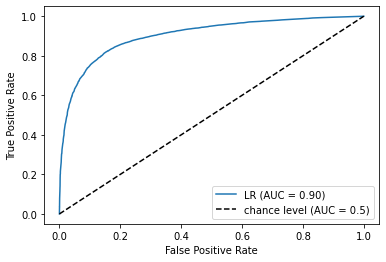

In [40]:
# ROC
from sklearn.metrics import RocCurveDisplay, roc_curve, auc 
fpr, tpr, thresholds = roc_curve(y_test,
                                clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                        estimator_name='LR')
display.plot()

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.savefig('figs/roc_lr.png', dpi=200)

#### Weights of LR


In [42]:
weight_col_name = list(np.append(cat_names, 'age'))
df_weight = pd.DataFrame(clf.coef_, columns=weight_col_name)
df_weight

,gender_f,gender_m,education_level_Associate's degree,education_level_College degree,education_level_High school diploma/GED,education_level_Master's degree,education_level_Other,education_level_Ph.D.,education_level_Professional degree,education_level_Some college,education_level_Some high school,country_AU,country_CA,country_NZ,country_US,age
0,0.246041,0.0,0.337527,-0.575464,1.195757,-0.790337,1.369141,-0.975901,-0.764078,0.356304,2.092697,0.0,0.136424,0.0,0.034998,2.122783


We have low cognitive ability labeled as 1, and high cognitive ability labeled as 0.<br>
Therefore, a large weight means the feature is predictive for low cognitive ability.<br>

1. Positive weight in **female**, which is plausible given the higher propotion of low ability in female.<br>
2. A perfect decreasing trend of weight from *Some High School* to *Ph.D*, meaning longer educational is associted with higher cognitive ability.
    - We do not claim causality here, though we hypothesize it could come in both direction.  
3. Low weights in either country, as we anticipated before.
4. Large weight in **age**.
    - Cognitive imparement with age growth.

To sum up, the predictive ability of features revealed by weights matches our anticipation.

#### Cases where LR makes mistakes

In [43]:
mask = y_test == clf.predict(X_test)
# index 0, success; index 7, failure 

In [44]:
# let's look at a case where LR suceeds 
df_s = pd.DataFrame(X_test[0,:].reshape(1,-1), columns=weight_col_name)
df_s

,gender_f,gender_m,education_level_Associate's degree,education_level_College degree,education_level_High school diploma/GED,education_level_Master's degree,education_level_Other,education_level_Ph.D.,education_level_Professional degree,education_level_Some college,education_level_Some high school,country_AU,country_CA,country_NZ,country_US,age
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.003393


In [45]:
# let's look at a case where LR fails 
df_f = pd.DataFrame(X_test[7,:].reshape(1,-1), columns=weight_col_name)
df_f

,gender_f,gender_m,education_level_Associate's degree,education_level_College degree,education_level_High school diploma/GED,education_level_Master's degree,education_level_Other,education_level_Ph.D.,education_level_Professional degree,education_level_Some college,education_level_Some high school,country_AU,country_CA,country_NZ,country_US,age
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.394858


In [46]:
print(f"Ture label is {y_test[7]}")

Ture label is 0


In this case, the subject's age is relatively old. <br>
In addtion, she has a college degree.<br>
Recall that age has a much higher weight than college.<br>
However, she has high cognitive ability.<br>
As our LR model have learned a negative relationship between age and cognitive ability, it is understandable why the model misclassify this subject.

### 2.3 Random Forest (RF) (Shan Gao)

#### Data Preparation

Remember that we standardized age values for logistic regression.

For random forest, we convert age back to its original values for easier interpretaion of results.

In [47]:
X[:,-1] = scaler.inverse_transform(X[:,-1].reshape(-1,1)).flatten() 

In [48]:
# sanity check
X[:,-1]

array([79., 51., 33., ..., 27., 20., 25.])

Update the training and test sets after converting age back to its original values

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#### Parameter Selection

For RF, we are agnostic of the following parameters:

- max_depth
- min_samples_split
- min_samples_leaf
- max_leaf_nodes

We use grid search to determine the best combination of parameters.

Due to the limit of computational power, in order for the grid search to complete in an acceptable amount of time, we only search for the optimal min_samples_split and max_leaf_nodes using grid search and will explore the other two parameters manually.

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
rf_clf = RandomForestClassifier(random_state=42)
parameters = [{'min_samples_split': np.linspace(0.05, 0.6, num=10),
            'max_leaf_nodes': np.arange(2,20,3)}]

grid_search = GridSearchCV(estimator=rf_clf,  
                           param_grid=parameters,
                           scoring='roc_auc', # we use auc as the evaluation of the model 
                           cv=10)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_leaf_nodes': array([ 2,  5,  8, 11, 14, 17]),
                          'min_samples_split': array([0.05      , 0.11111111, 0.17222222, 0.23333333, 0.29444444,
       0.35555556, 0.41666667, 0.47777778, 0.53888889, 0.6       ])}],
             scoring='roc_auc')

The results of grid search:

In [52]:
print(f'Best AUC score: {grid_search.best_score_}')

print(f'Best parameter combination: {grid_search.best_params_}')

# save variable for easier future use
%store grid_search
# %store -r grid_search

Best AUC score: 0.8980094672070242
Best parameter combination: {'max_leaf_nodes': 17, 'min_samples_split': 0.05}
Stored 'grid_search' (GridSearchCV)


#### Model Training

We then train the RF classifier model with optimized parameters

In [53]:
rf_clf = RandomForestClassifier(max_leaf_nodes=17,
                                min_samples_split=0.05,
                                random_state=42).fit(X_train, y_train)

#### Model Evaluation I

We first evaluate the model's performance with the .score() method:

In [54]:
print(f'Test Accuracy: {round(rf_clf.score(X_test, y_test), 3)}')

Test Accuracy: 0.827


#### Further Parameter Tuning

Remember that we were only able to explore two parameters (min_samples_split and max_leaf_nodes) with grid search. Now we'd like to explore the other two parameter we are agnostic about (max_depth and min_samples_leaf) manually and see if how the model performance change.

##### max_depth

Explore max_depth = 5:

In [55]:
rf_clf.set_params(**{'max_depth':5})
rf_clf.fit(X_train, y_train)

print('model accuracy:', round(rf_clf.score(X_test, y_test), 3))

model accuracy: 0.826


Explore max_depth = 3:

In [56]:
rf_clf.set_params(**{'max_depth':3})
rf_clf.fit(X_train, y_train)

print('model accuracy:', round(rf_clf.score(X_test, y_test), 3))

model accuracy: 0.824


We see that the model performance is similar, though slightly lower with the decrease of max_depth. Thus, we revert max_depth to None:

In [57]:
rf_clf.set_params(**{'max_depth':None})
rf_clf.fit(X_train, y_train)

print('model accuracy:', round(rf_clf.score(X_test, y_test), 3))

model accuracy: 0.827


##### min_samples_leaf

Explore min_samples_leaf = 200:

In [58]:
rf_clf.set_params(**{'min_samples_leaf':200})
rf_clf.fit(X_train, y_train)

print('model accuracy:', round(rf_clf.score(X_test, y_test), 3))

model accuracy: 0.826


Explore min_samples_leaf = 500:

In [59]:
rf_clf.set_params(**{'min_samples_leaf':500})
rf_clf.fit(X_train, y_train)

print('model accuracy:', round(rf_clf.score(X_test, y_test), 3))

model accuracy: 0.825


Explore min_samples_leaf = 1000:

In [60]:
rf_clf.set_params(**{'min_samples_leaf':1000})
rf_clf.fit(X_train, y_train)

print('model accuracy:', round(rf_clf.score(X_test, y_test), 3))

model accuracy: 0.824


We see that the model performance is similar, though slightly lower with the increase of min_samples_leaf. Thus, we revert min_samples_leaf to its default setting 1:

In [61]:
rf_clf.set_params(**{'min_samples_leaf':1})
rf_clf.fit(X_train, y_train)

print('model accuracy:', round(rf_clf.score(X_test, y_test), 3))

model accuracy: 0.827


#### Model Evaluation II

We then use the following metrics to further evaluate our best-performing model (parameters: max_leaf_nodes=17, min_samples_split=0.05, max_depth=None, min_samples_leaf=1):
- Accuracy
- Precision
- Recall
- F-measure
- Confusion Matrix
- ROC(AUC score)

In [62]:
# precision, recall, f-measure
from sklearn.metrics import classification_report
y_predict = rf_clf.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     12502
           1       0.84      0.80      0.82     12570

    accuracy                           0.83     25072
   macro avg       0.83      0.83      0.83     25072
weighted avg       0.83      0.83      0.83     25072



We observe a balanced classification of high and low class.<br>
Therefore, we would anticipate a balanced confusion matrix.

In [63]:
# confusion matrix 
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_predict))

[[10640  1862]
 [ 2477 10093]]


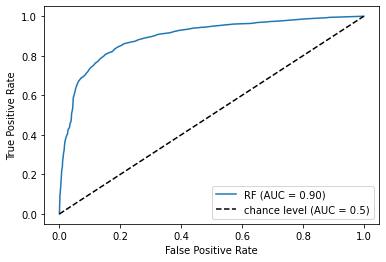

In [64]:
# ROC
from sklearn.metrics import RocCurveDisplay, roc_curve, auc 
fpr, tpr, thresholds = roc_curve(y_test,
                                rf_clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                        estimator_name='RF')
display.plot()

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.savefig('figs/roc_rf.png', dpi=200)

We see from the plot that our RF model has an AUC of 0.90

#### Visualization

Let's take a look at what a tree in our RF looks like

In [66]:
from sklearn import tree
import graphviz

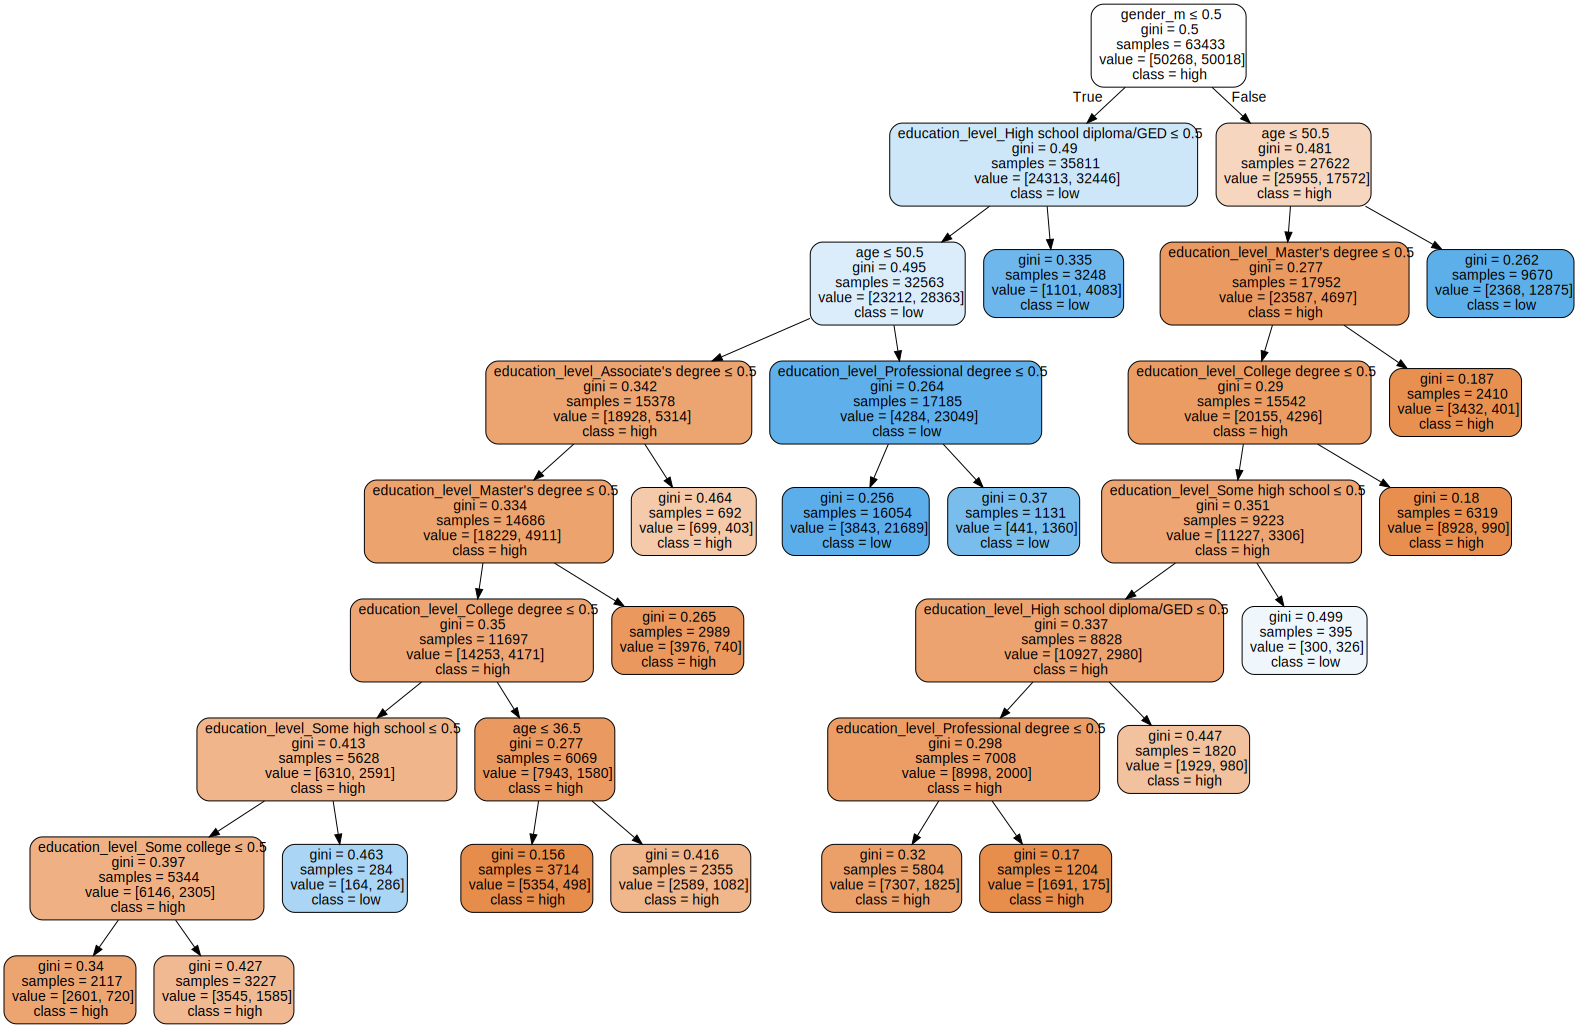

In [67]:
dot_data = tree.export_graphviz(rf_clf.estimators_[0], out_file=None, 
                                feature_names= weight_col_name,
                                class_names=['high', 'low'],
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [68]:
# save graph for future access
graph.render(filename='figs/tree1.dot')

'figs/tree1.dot.pdf'

Let's check out one more tree:

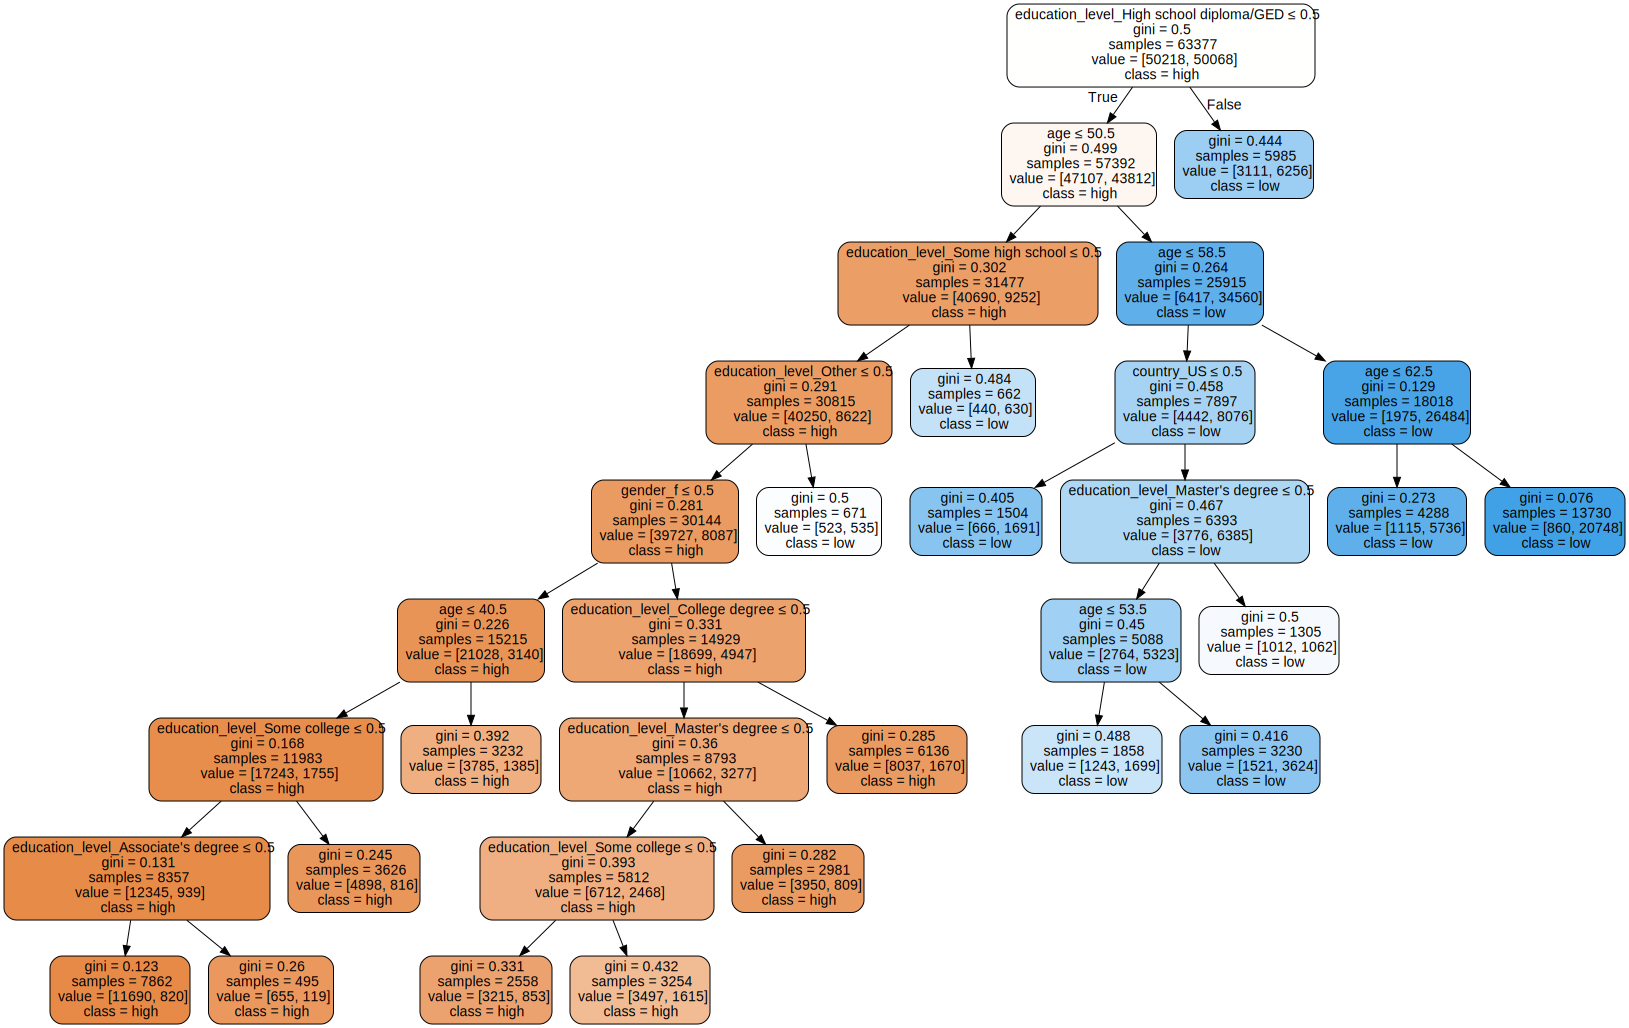

In [69]:
dot_data = tree.export_graphviz(rf_clf.estimators_[9], out_file=None, 
                                feature_names= weight_col_name,
                                class_names=['high', 'low'],
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [70]:
# save graph for future access
graph.render(filename='figs/tree10.dot')

'figs/tree10.dot.pdf'

Note that for one-hot encoded categorical features, not have a certain feature is coded as 0, whereas having this feature is coded as 1.

We can see from the graphs that our RF model:

- has learned a strong negative association between **age** and cognitive performance. In both trees we've visualized here, having an age > 50.5 is highly reliably associated with low cognitive performance, whereas having an age $\leq$ 50.5 is highly reliably associated with high cognitive performance.

- has learned a positive association between **educational level** and cognitive performance. For example, participants with only "Some high school" education are almost always predicted to have a low cognitive performance, whereas participants with "Some college" education or "College degree" are usually predicted to have high cognitive performance. Nevertheless, educational level seems not to be as strong a predictor for cognitive performance as age, especially for certain educational levels. For example, participants with "Master's degree" can be predicted to have either a low or high cognitive performance according to the information on the second graph, depending on the split at ancester nodes according to age.

- sometimes also uses **gender** to split data, but far less frequently compared to age and educational level. Additionally, it is also not as predictive for cognitive performance as age and educational level. For example, in the first graph, after splitting by gender, there are participants predicted (further by age and educational level) to have both high and low coginitive performance within each gender class; and in the second graph, after splitting according to age and educational level, further splitting by gender does not lead to different cognitive performance prediction by gender.

- rarely uses **country** to split data; and when the model does use country, it does not lead to different cognitive performance prediction by country. Therefore, country is likely not predictive in our RF model.


#### When does our RF classifer fail?

We first generate a mask about whether our model has made the correct prediction:

In [71]:
mask = y_test == rf_clf.predict(X_test)

After inspecting the *mask* np array in data viewer, we found that, similar to logistic regression model, our RF model also makes successful prediction for the test observation at in index 0, and makes false prediction for the test observation at in index 7.

Model success: index 0

In [72]:
# RF success: index 0

print(f"Successfully predicted the true label: {y_test[0]} \n(remember that we coded high cognitive performance as 0 and low cognitive performance as 1)")

df_s = pd.DataFrame(X_test[0,:].reshape(1,-1), columns=weight_col_name)
df_s

Successfully predicted the true label: 0 
(remember that we coded high cognitive performance as 0 and low cognitive performance as 1)


,gender_f,gender_m,education_level_Associate's degree,education_level_College degree,education_level_High school diploma/GED,education_level_Master's degree,education_level_Other,education_level_Ph.D.,education_level_Professional degree,education_level_Some college,education_level_Some high school,country_AU,country_CA,country_NZ,country_US,age
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,47.0


We note that this participant has an age of $\leq$ 50.5 and a high level of education (Master's degree). According to our above analysis of the model, it makes sense that our RF model correctly classified him as having a high cognitive performance.

Model failure: index 7

In [73]:
# RF failure: index 7

print(f"Wrongly predicted the true label: {y_test[7]} \n(remember that we coded high cognitive performance as 0 and low cognitive performance as 1)")

df_f = pd.DataFrame(X_test[7,:].reshape(1,-1), columns=weight_col_name)
df_f

Wrongly predicted the true label: 0 
(remember that we coded high cognitive performance as 0 and low cognitive performance as 1)


,gender_f,gender_m,education_level_Associate's degree,education_level_College degree,education_level_High school diploma/GED,education_level_Master's degree,education_level_Other,education_level_Ph.D.,education_level_Professional degree,education_level_Some college,education_level_Some high school,country_AU,country_CA,country_NZ,country_US,age
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,54.0


This participant has an age of > 50.5 but has a high cognitive performance.

According to our analysis above, our RF model have learned a negtive relationship between age and cognitive performance (such that higher age value leads to low cognitive performance prediction), it is not surprising why the RF model also misclassified this participant's cognitive performance.

### 2.4 Model Comparison

Taking **AUC** as example, 0.9 for LR and 0.9 for RF.<br>
We have a similar performance in two different models. 

## Part 3 Conclusion

In conclusion, we could use two different models (LR and RF) to successfully classify cognitive ability with demographic data.<br>
Both *age* and *educational level* are important for prediction.

## 